In [1]:
# Import some libraries

import torch
import torchvision
from torch import nn
from torch.utils.data import DataLoader
from torchvision import transforms
import torchvision.datasets as datasets

import os
import pickle
import numpy as np

from skimage import io

from matplotlib import pyplot as plt
%matplotlib inline

import matplotlib as mpl
mpl.rcParams['axes.grid'] = False
mpl.rcParams['image.interpolation'] = 'nearest'
mpl.rcParams['figure.figsize'] = 15, 25

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [26]:
np.random.seed(0)
torch.manual_seed(0)

data = "parts_data"
batch_size = 256
workers = 4
distributed = False

# Data loading code
train_dir = os.path.join(data, 'train')
val_dir = os.path.join(data, 'val')
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
class NormalizeInverse(torchvision.transforms.Normalize):
    """
    Ref: https://discuss.pytorch.org/t/simple-way-to-inverse-transform-normalization/4821
    Undoes the normalization and returns the reconstructed images in the input domain.
    """

    def __init__(self, mean, std):
        mean = torch.as_tensor(mean)
        std = torch.as_tensor(std)
        std_inv = 1 / (std + 1e-7)
        mean_inv = -mean * std_inv
        super().__init__(mean=mean_inv, std=std_inv)

    def __call__(self, tensor):
        return super().__call__(tensor.clone())
inv_normalize = NormalizeInverse(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

# Ref: https://pytorch.org/docs/stable/torchvision/transforms.html

train_dataset = datasets.ImageFolder(
    train_dir,
    transforms.Compose([
#         transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        normalize,
    ]))

if distributed:
    train_sampler = torch.utils.data.distributed.DistributedSampler(train_dataset)
else:
    train_sampler = None

train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, shuffle=(train_sampler is None),
        num_workers=workers, pin_memory=True, sampler=train_sampler)

val_loader = torch.utils.data.DataLoader(
    datasets.ImageFolder(val_dir, transforms.Compose([
#         transforms.Grayscale(num_output_channels=1),
        transforms.ToTensor(),
        normalize,
    ])),
    batch_size=batch_size, shuffle=False,
    num_workers=workers, pin_memory=True)

# input_dim = io.imread(train_dataset.imgs[0][0]).transpose(2,0,1).shape
# nw_input_dim = (batch_size,) + input_dim

input_dim = (3, ) + io.imread(train_dataset.imgs[0][0]).shape
input_dim = (3, 256, 306)

In [27]:
train_dataset.classes[y[i].item()]

'114_39'

torch.Size([256, 3, 128, 128])


ValueError: num must be 1 <= num <= 36, not 37

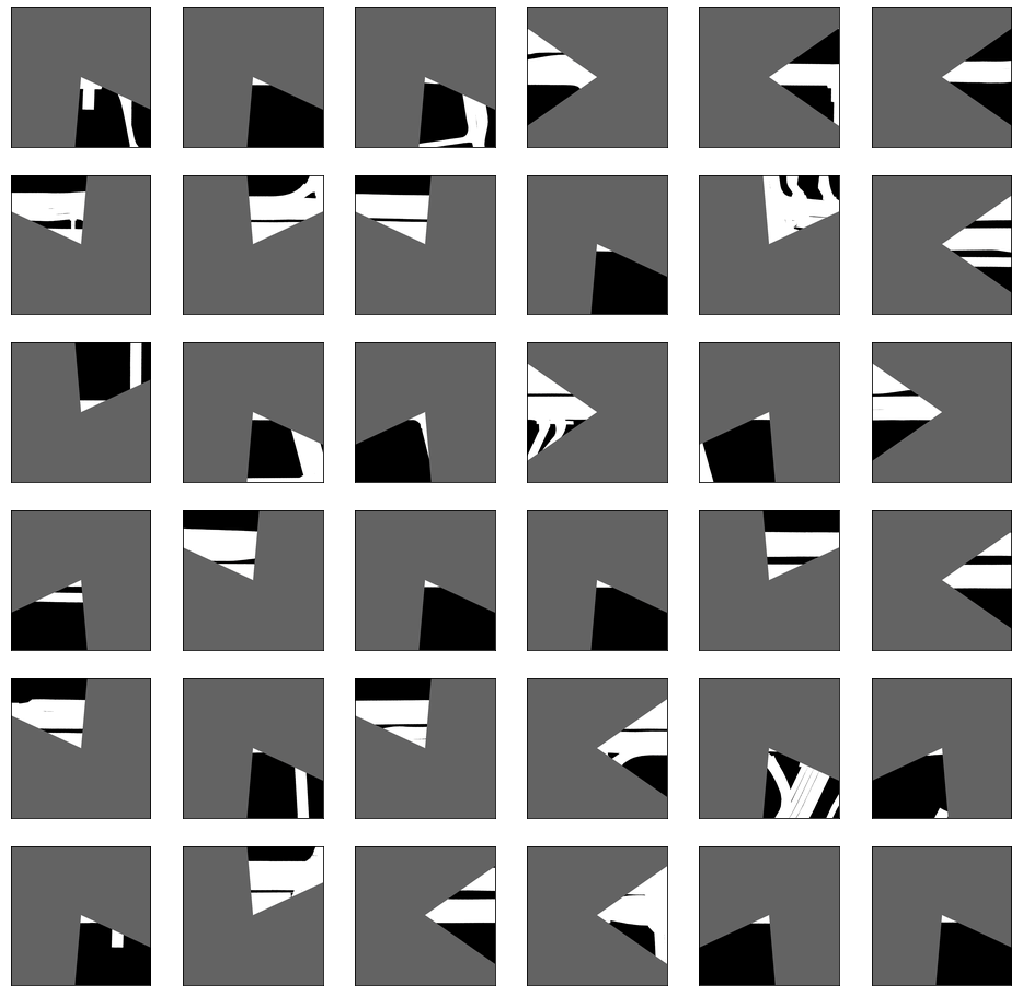

In [28]:
X, y = iter(train_loader).next()
print(X.shape)
plt.figure(figsize=(18,18))
for i in range(len(X)):
    plt.subplot(6,6,i+1)
    plt.imshow(torch.clamp(inv_normalize(X[i]), 0, 1).permute(1,2,0))
    plt.xticks([]), plt.yticks([])
plt.tight_layout()

In [ ]:
y

In [9]:
import ConvAE_AutoConf as ConvAE

input_dim = (3, 800, 800)
feature_maps = 96
depth = 8
pooling_freq = 1e100 # large number to disable pooling layers
batch_norm_freq = 2
strided_conv_freq = 2
strided_conv_feature_maps = 8
code_size = 8

CONV_ENC_BLOCK = [("conv1", feature_maps), ("relu1", None)]
CONV_ENC_LAYERS = ConvAE.create_network(
    CONV_ENC_BLOCK, depth, 
    pooling_freq=pooling_freq,
    strided_conv_freq=strided_conv_freq, 
    strided_conv_channels=strided_conv_feature_maps,
    batch_norm_freq=batch_norm_freq)

CONV_ENC_NW = CONV_ENC_LAYERS + [("flatten1", None), ("linear1", 1024), ("relu1", None), ("linear1", 64)]
model = ConvAE.ConvAE(input_dim, enc_config=CONV_ENC_NW, store_activations=False)
# print("Encoder Nw Spec:")
# CONV_ENC_NW
print(model)

ConvAE(
  (encoder): ModuleList(
    (0): Conv2d(3, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): ReLU()
    (2): Conv2d(96, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (3): ReLU()
    (4): Conv2d(96, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (5): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Conv2d(8, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (7): ReLU()
    (8): Conv2d(96, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (9): ReLU()
    (10): Conv2d(96, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (11): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): Conv2d(8, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (13): ReLU()
    (14): Conv2d(96, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (15): ReLU(

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.size()[0], -1)

class DeFlatten(nn.Module):
    def __init__(self, *args):
        super(DeFlatten, self).__init__()
        self.shape = args

    def forward(self, x):
        return x.view(self.shape)

In [32]:
class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
            nn.ReLU(),
            nn.Conv2d(96, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
            nn.ReLU(),
            nn.Conv2d(96, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False),
            nn.BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.Conv2d(8, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
            nn.ReLU(),
            nn.Conv2d(96, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
            nn.ReLU(),
            nn.Conv2d(96, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False),
            nn.BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            Flatten(),
            nn.Linear(in_features=8192, out_features=1024, bias=True),
            nn.ReLU(),
            nn.Linear(in_features=1024, out_features=64, bias=True)
        )
        self.decoder = nn.Sequential(
            nn.Linear(in_features=64, out_features=1024, bias=True),
            nn.ReLU(),
            nn.Linear(in_features=1024, out_features=8192, bias=True),
            DeFlatten(-1, 8, 32, 32),
            nn.BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ConvTranspose2d(8, 96, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding = (1, 1), dilation = (1,1), bias=False),
            nn.ReLU(),
            nn.ConvTranspose2d(96, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
            nn.ReLU(),
            nn.ConvTranspose2d(96, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
            nn.BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ConvTranspose2d(8, 96, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding = (1, 1), dilation = (1,1), bias=False),
            nn.ReLU(),
            nn.ConvTranspose2d(96, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
            nn.ReLU(),
            nn.ConvTranspose2d(96, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )

    def forward(self, x):
        x = self.encoder(x)
        noise = Variable(torch.randn(x.size()) * 0.3)
        x = self.decoder(x + noise)
        return x
    
model = Autoencoder().to(device)
criterion = nn.MSELoss()

In [43]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
            nn.ReLU(),
            nn.Conv2d(96, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
            nn.BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.Conv2d(96, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
            nn.ReLU(),
            nn.Conv2d(96, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
            nn.BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.Conv2d(96, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
            nn.ReLU(),
            nn.Conv2d(96, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
            nn.Conv2d(96, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False),
            nn.BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.Conv2d(32, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
            nn.ReLU(),
            nn.Conv2d(96, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
            nn.BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.Conv2d(96, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
            nn.ReLU(),
            nn.Conv2d(96, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
            nn.BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            Flatten(),
            nn.Linear(in_features=1536, out_features=1024, bias=True),
            nn.ReLU(),
            nn.Linear(in_features=1024, out_features=256, bias=True),
            nn.ReLU(),
            nn.Linear(in_features=256, out_features=64, bias=True),
        )
    def forward(self, x):
        x = self.encoder(x)
        return x


In [12]:
# model = CNN()
from torchsummary import summary
from torchvision import models

summary(model, (3, 800, 800))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 96, 800, 800]           2,592
              ReLU-2         [-1, 96, 800, 800]               0
            Conv2d-3         [-1, 96, 800, 800]          82,944
              ReLU-4         [-1, 96, 800, 800]               0
            Conv2d-5          [-1, 8, 400, 400]           6,912
       BatchNorm2d-6          [-1, 8, 400, 400]              16
            Conv2d-7         [-1, 96, 400, 400]           6,912
              ReLU-8         [-1, 96, 400, 400]               0
            Conv2d-9         [-1, 96, 400, 400]          82,944
             ReLU-10         [-1, 96, 400, 400]               0
           Conv2d-11          [-1, 8, 200, 200]           6,912
      BatchNorm2d-12          [-1, 8, 200, 200]              16
           Conv2d-13         [-1, 96, 200, 200]           6,912
             ReLU-14         [-1, 96, 2

In [47]:
from torchsummary import summary
from torchvision import models

model = models.resnet18()

model.fc = nn.Linear(512, 64)

summary(model, (3, 256, 306))
# print(model)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 153]           9,408
       BatchNorm2d-2         [-1, 64, 128, 153]             128
              ReLU-3         [-1, 64, 128, 153]               0
         MaxPool2d-4           [-1, 64, 64, 77]               0
            Conv2d-5           [-1, 64, 64, 77]          36,864
       BatchNorm2d-6           [-1, 64, 64, 77]             128
              ReLU-7           [-1, 64, 64, 77]               0
            Conv2d-8           [-1, 64, 64, 77]          36,864
       BatchNorm2d-9           [-1, 64, 64, 77]             128
             ReLU-10           [-1, 64, 64, 77]               0
       BasicBlock-11           [-1, 64, 64, 77]               0
           Conv2d-12           [-1, 64, 64, 77]          36,864
      BatchNorm2d-13           [-1, 64, 64, 77]             128
             ReLU-14           [-1, 64,

In [ ]:
# Configure the optimiser

learning_rate = 1e-3

optimizer = torch.optim.Adam(
    model.parameters(),
    lr=learning_rate,
)

In [23]:
# Displaying routine

def display_images(in_, out, n=1):
    for N in range(n):
        if in_ is not None:
            in_pic = to_img(in_.cpu().data)
            plt.figure(figsize=(18, 6))
            for i in range(4):
                plt.subplot(1,4,i+1)
                plt.imshow(in_pic[i+4*N])
                plt.axis('off')
        out_pic = to_img(out.cpu().data)
        plt.figure(figsize=(18, 6))
        for i in range(4):
            plt.subplot(1,4,i+1)
            plt.imshow(out_pic[i+4*N])
            plt.axis('off')

In [24]:
# Convert vector to image

def to_img(x):
    x = 0.5 * (x + 1)
    x = x.view(x.size(0), 28, 28)
    return x

In [ ]:
# Train standard or denoising autoencoder (AE)

num_epochs = 1
for epoch in range(num_epochs):
    for data in train_loader:
        img, _ = data
        img = img.to(device)
        # ===================forward=====================
        output = model(img)  # feed <img> (for std AE) or <img_bad> (for denoising AE)
        loss = criterion(output, img.data)
        # ===================backward====================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # ===================log========================
        print(f'epoch [{epoch + 1}/{num_epochs}], loss:{loss.item():.4f}')
    display_images(None, output)  # pass (None, output) for std AE, (img_bad, output) for denoising AE

In [29]:
out, code = model(X)
code

tensor([[-0.0349, -0.3413, -0.0890,  ..., -0.0262,  0.0744,  0.0523],
        [-0.0126, -0.2566, -0.0910,  ..., -0.0681,  0.0760,  0.1393],
        [-0.0027, -0.2601, -0.1302,  ..., -0.0485,  0.0139,  0.0435],
        ...,
        [-0.1074,  0.0227,  0.1682,  ..., -0.1505,  0.0291, -0.0524],
        [ 0.0267, -0.2297, -0.1341,  ..., -0.0623,  0.1036,  0.1470],
        [ 0.0034, -0.1981,  0.1188,  ..., -0.0243, -0.2028, -0.1521]],
       grad_fn=<AddmmBackward>)

In [31]:
X.shape

torch.Size([32, 3, 128, 128])

In [30]:
code.shape

torch.Size([32, 256])

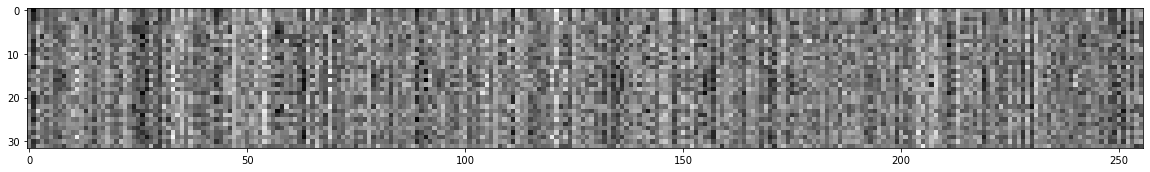

In [26]:
plt.figure(figsize=(20,20))
plt.imshow(code.detach().numpy(), cmap="gray")

In [27]:
out_normalized = torch.clamp(
    model.get_results_img(torch.stack([inv_normalize(img.detach()) for img in X]), 
                                       torch.stack([inv_normalize(img.detach()) for img in out])), 0, 1)

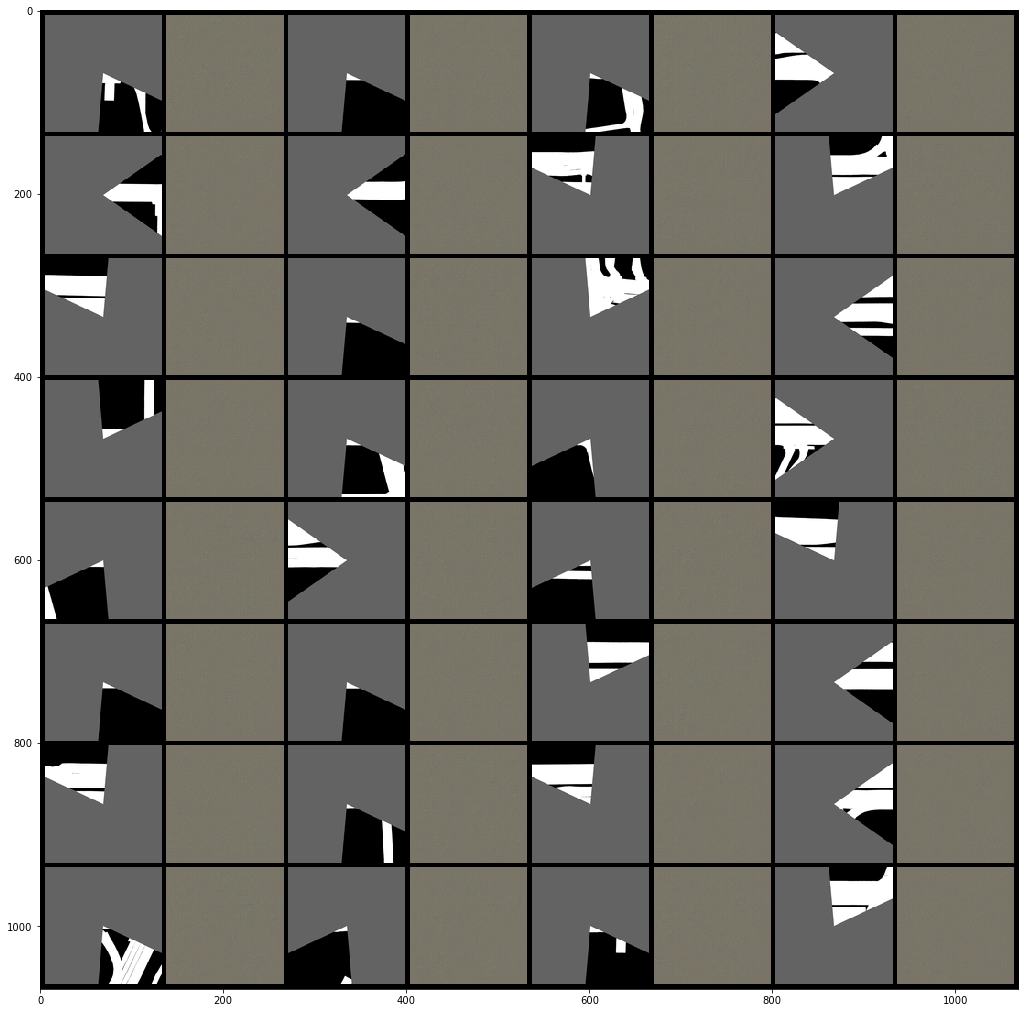

In [28]:
plt.figure(figsize=(18,18))
plt.imshow(out_normalized.detach())

In [33]:
import ConvAE_AutoConf as ConvAE

input_dim = (3, 800, 800)
feature_maps = 96
depth = 15
pooling_freq = 1e100 # large number to disable pooling layers
batch_norm_freq = 2
strided_conv_freq = 2
strided_conv_feature_maps = 8
code_size = 8

CONV_ENC_BLOCK = [("conv1", feature_maps), ("relu1", None)]
CONV_ENC_LAYERS = ConvAE.create_network(
    CONV_ENC_BLOCK, depth, 
    pooling_freq=pooling_freq,
    strided_conv_freq=strided_conv_freq, 
    strided_conv_channels=strided_conv_feature_maps,
    batch_norm_freq=batch_norm_freq)

CONV_ENC_NW = CONV_ENC_LAYERS + [("flatten1", None), ("linear1", 1024), ("relu1", None), ("linear1", 64)]
model = ConvAE.ConvAE(input_dim, enc_config=CONV_ENC_NW, store_activations=False)
# print("Encoder Nw Spec:")
# CONV_ENC_NW
print(model)

ConvAE(
  (encoder): ModuleList(
    (0): Conv2d(3, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): ReLU()
    (2): Conv2d(96, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (3): ReLU()
    (4): Conv2d(96, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (5): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Conv2d(8, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (7): ReLU()
    (8): Conv2d(96, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (9): ReLU()
    (10): Conv2d(96, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (11): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): Conv2d(8, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (13): ReLU()
    (14): Conv2d(96, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (15): ReLU(

In [34]:
summary(model, (3, 800, 800))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 96, 800, 800]           2,592
              ReLU-2         [-1, 96, 800, 800]               0
            Conv2d-3         [-1, 96, 800, 800]          82,944
              ReLU-4         [-1, 96, 800, 800]               0
            Conv2d-5          [-1, 8, 400, 400]           6,912
       BatchNorm2d-6          [-1, 8, 400, 400]              16
            Conv2d-7         [-1, 96, 400, 400]           6,912
              ReLU-8         [-1, 96, 400, 400]               0
            Conv2d-9         [-1, 96, 400, 400]          82,944
             ReLU-10         [-1, 96, 400, 400]               0
           Conv2d-11          [-1, 8, 200, 200]           6,912
      BatchNorm2d-12          [-1, 8, 200, 200]              16
           Conv2d-13         [-1, 96, 200, 200]           6,912
             ReLU-14         [-1, 96, 2

In [17]:
class Autoencoder_800(nn.Module):
    def __init__(self):
        super().__init__()
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
            nn.LeakyReLU(),
            nn.Conv2d(96, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
            nn.LeakyReLU(),
            nn.Dropout(p = 0.8),
            nn.Conv2d(96, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False),
            nn.BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.Conv2d(8, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
            nn.LeakyReLU(),
            nn.Conv2d(96, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
            nn.LeakyReLU(),
            nn.Dropout(p = 0.8),
            nn.Conv2d(96, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False),
            nn.BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.Conv2d(8, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
            nn.LeakyReLU(),
            nn.Dropout(p = 0.8),
            nn.Conv2d(96, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
            nn.LeakyReLU(),
            nn.Conv2d(96, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False),
            nn.BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.Conv2d(8, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
            nn.LeakyReLU(),
            nn.Conv2d(96, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
            nn.LeakyReLU(),
            nn.Dropout(p = 0.8),
            nn.Conv2d(96, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False),
            nn.BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.Conv2d(8, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
            nn.LeakyReLU(),
            nn.Conv2d(96, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
            nn.LeakyReLU(),
            nn.Dropout(p = 0.8),
            nn.Conv2d(96, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False),
            nn.BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.Conv2d(8, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
            nn.LeakyReLU(),
            nn.Conv2d(96, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
            nn.LeakyReLU(),
            nn.Dropout(p = 0.8),
            nn.Conv2d(96, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False),
            nn.BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.Conv2d(8, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
            nn.LeakyReLU(),
            nn.Conv2d(96, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
            nn.LeakyReLU(),
            nn.Dropout(p = 0.8),
            nn.Conv2d(96, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False),
            nn.BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.Conv2d(8, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
            nn.LeakyReLU(),
            Flatten(),
            nn.Linear(in_features=4704, out_features=1024, bias=True),
            nn.LeakyReLU(),
            nn.Linear(in_features=1024, out_features=64, bias=True)
        )
        self.decoder = nn.Sequential(
            nn.Linear(in_features=64, out_features=1024, bias=True),
            nn.LeakyReLU(),
            nn.Linear(in_features=1024, out_features=4704, bias=True),
            DeFlatten(-1, 96, 7, 7),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(96, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
            nn.BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ConvTranspose2d(8, 96, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(96, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(96, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
            nn.BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ConvTranspose2d(8, 96, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(96, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(96, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
            nn.BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ConvTranspose2d(8, 96, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding = (1, 1), dilation = (1,1), bias=False),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(96, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(96, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
            nn.BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ConvTranspose2d(8, 96, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding = (1, 1), dilation = (1,1), bias=False),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(96, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(96, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
            nn.BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ConvTranspose2d(8, 96, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding = (1, 1), dilation = (1,1), bias=False),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(96, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(96, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
            nn.BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ConvTranspose2d(8, 96, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding = (1, 1), dilation = (1,1), bias=False),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(96, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(96, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
            nn.BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ConvTranspose2d(8, 96, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding = (1, 1), dilation = (1,1), bias=False),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(96, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(96, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)

        )

    def forward(self, x):
        x = self.encoder(x)
        noise = Variable(torch.randn(x.size()) * 0.3)
        x = self.decoder(x + noise)
        return x

device = 'cpu'
model = Autoencoder_800().to(device)
criterion = nn.MSELoss()

In [18]:
from torchsummary import summary
from torchvision import models
from torch.autograd import Variable

summary(model, (3, 800, 800))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 96, 800, 800]           2,592
         LeakyReLU-2         [-1, 96, 800, 800]               0
            Conv2d-3         [-1, 96, 800, 800]          82,944
         LeakyReLU-4         [-1, 96, 800, 800]               0
           Dropout-5         [-1, 96, 800, 800]               0
            Conv2d-6          [-1, 8, 400, 400]           6,912
       BatchNorm2d-7          [-1, 8, 400, 400]              16
            Conv2d-8         [-1, 96, 400, 400]           6,912
         LeakyReLU-9         [-1, 96, 400, 400]               0
           Conv2d-10         [-1, 96, 400, 400]          82,944
        LeakyReLU-11         [-1, 96, 400, 400]               0
          Dropout-12         [-1, 96, 400, 400]               0
           Conv2d-13          [-1, 8, 200, 200]           6,912
      BatchNorm2d-14          [-1, 8, 2